In [31]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Setup

In [80]:
from make_analytic_table import AnalyticTableConstructor

atc = AnalyticTableConstructor(db_path="data/drafts.sqlite", validate_data=False)
X, y, y_names_mapping = atc.make_analytic_base_table()

In [81]:
N_CARDS = int(X.shape[1] / 2)

assert X.shape[1] == N_CARDS * 2

When there is more than one of a single card in a pack, we want to consider that just a single copy of that card for convenience.  Otherwise, we would have to apply this logic inside the model fitting logic, and track the gradient of this transformation.

In real (non-simulated) packs, this situation cannot happen anyway.

In [82]:
X.iloc[:, 0:N_CARDS] = np.sign(X.iloc[:, 0:N_CARDS])

In [83]:
N_TRAINING = int(2 * X.shape[0] / 3)

train = TensorDataset(
    torch.from_numpy(X[:N_TRAINING].values.astype(np.float32)),
    torch.from_numpy(y[:N_TRAINING].values))
test = TensorDataset(
    torch.from_numpy(X[N_TRAINING:].values.astype(np.float32)),
    torch.from_numpy(y[N_TRAINING:].values))

train_batcher = DataLoader(train, batch_size=42*25)
test_batcher = DataLoader(test, batch_size=42*25)

## Load and Fit the Model

In [111]:
from draftbot_learn import DraftBotModel, DraftBotModelTrainer

In [85]:
def log_loss(logps, ys):
    return -torch.mean(logps[range(ys.shape[0]), ys])

In [110]:
loss_function = torch.nn.NLLLoss()

In [112]:
draftbot = DraftBotModel(n_cards=N_CARDS, n_archetypes=10)
trainer = DraftBotModelTrainer(loss_function=torch.nn.NLLLoss())

In [113]:
trainer.fit(draftbot, train_batcher, test_batcher=test_batcher)

Training loss, epoch 0: 1.296135688273328
Training loss, epoch 1: 0.687958974890879
Training loss, epoch 2: 0.516146991370287
Training loss, epoch 3: 0.42879151984264974
Training loss, epoch 4: 0.3734280849049573
Training loss, epoch 5: 0.33480305425784784
Training loss, epoch 6: 0.3064039760413113
Training loss, epoch 7: 0.2846740071862582
Training loss, epoch 8: 0.2674895120446265
Training loss, epoch 9: 0.2535222695416222
Training loss, epoch 10: 0.24191081602322428
Training loss, epoch 11: 0.23207636250907174
Training loss, epoch 12: 0.22361658199837334
Training loss, epoch 13: 0.21624301649718616
Training loss, epoch 14: 0.20974356910065195
Training loss, epoch 15: 0.2039586261344887
Training loss, epoch 16: 0.1987658682420015
Training loss, epoch 17: 0.1940700529437316
Training loss, epoch 18: 0.18979609665320157
Training loss, epoch 19: 0.1858841056582883
Training loss, epoch 20: 0.18228567762265585
Training loss, epoch 21: 0.17896132426674782
Training loss, epoch 22: 0.17587850

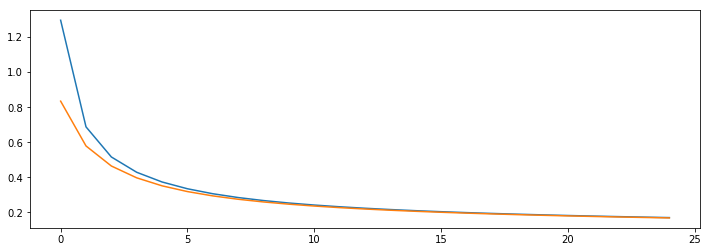

In [114]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(np.arange(trainer.n_epochs), trainer.epoch_training_losses)
ax.plot(np.arange(trainer.n_epochs), trainer.epoch_testing_losses)

### Plot Results

In [115]:
weights_df = pd.DataFrame(draftbot.weights.detach().numpy(),
                          index=y_names_mapping.values())

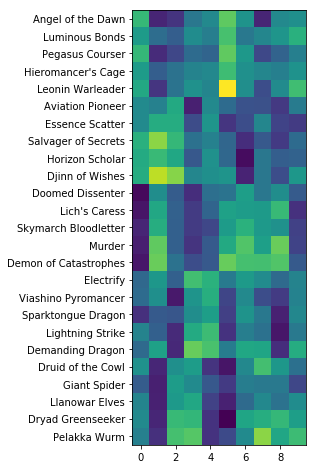

In [116]:
fig, ax = plt.subplots(figsize=(4, 8))

ax.imshow(weights_df.values)
ax.set_yticks(np.arange(len(weights_df)))
_ = ax.set_yticklabels(weights_df.index)